In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [ ]:
sequence_length=10
min_word_frequency=10
step=1
batch_size=192

**Shuffle and split training set**

In [ ]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [ ]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length), dtype=np.int32)
    y=np.zeros((batch_size), dtype=np.int32)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t]=word_indices[w]
      y[i]=word_indices[next_word_list[index%len(sentence_list)]]
      index+=1                                             
    yield x, y

**Write generated vocabulary to a file**

In [ ]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [ ]:
def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=1024))
    model.add(Bidirectional(LSTM(175, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(350, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(700, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(700)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(700, kernel_initializer='lecun_normal', activation='selu'))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(350, kernel_initializer='lecun_normal', activation='selu'))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(175, kernel_initializer='lecun_normal', activation='selu'))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [ ]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [ ]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length))
      for t, word in enumerate(sentence):
        x_pred[0, t]= word_indices[word]
      preds=model.predict(x_pred, verbose=0)[0]
      next_index=sample(preds, diversity)
      next_word=indices_word[next_index]
      sentence=sentence[1:]
      sentence.append(next_word)
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Kim Harrison**

In [ ]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Kim Harrison.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_kim_harrison.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_kim_harrison.txt'

In [ ]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints')

In [ ]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 9918782


In [ ]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 1851030


In [ ]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [ ]:
len(word_freq)

68184

In [ ]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [ ]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 68184
Unique words after ignoring: 11109


In [ ]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [ ]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [ ]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  985327
Remaning sentences:  865693
Number of words:  865693


In [ ]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 848379
Size of test set= 17314


In [ ]:
model=get_model()

Build model...
Done!


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

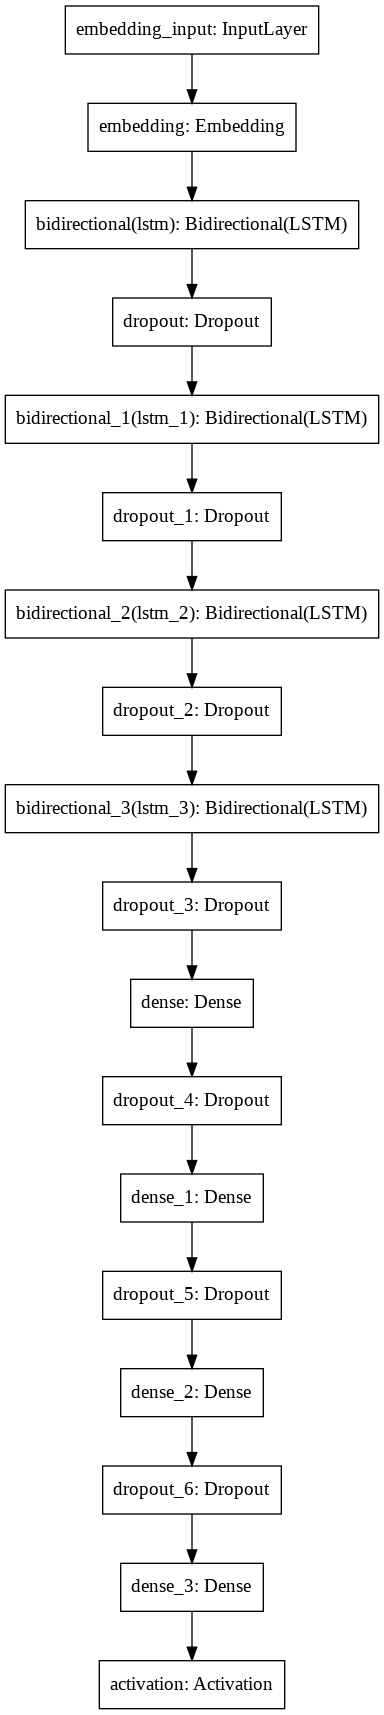

In [ ]:
plot_model(model, to_file='Kim Harrison Model.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1024)        11375616  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 350)         1680000   
_________________________________________________________________
dropout (Dropout)            (None, None, 350)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 700)         1962800   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 700)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 1400)        7845600   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 1400)        0

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=2)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
int(len(sentences_test)/batch_size)+1

91

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=10, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/model_kim_harrison.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/model_kim_harrison.h5")
print("Saved model to disk!")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
4419/4419 [==============================] - 1345s 295ms/step - loss: 6.3929 - accuracy: 0.0841 - val_loss: 5.3418 - val_accuracy: 0.1573


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch001-words11109-sequence10-minfreq10-loss5.9713-accuracy0.1147-val_loss5.3418-val_accuracy0.1573/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch001-words11109-sequence10-minfreq10-loss5.9713-accuracy0.1147-val_loss5.3418-val_accuracy0.1573/assets


Epoch 2/10
4419/4419 [==============================] - 1314s 297ms/step - loss: 5.3209 - accuracy: 0.1573 - val_loss: 5.0473 - val_accuracy: 0.1744


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch002-words11109-sequence10-minfreq10-loss5.2467-accuracy0.1621-val_loss5.0473-val_accuracy0.1744/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch002-words11109-sequence10-minfreq10-loss5.2467-accuracy0.1621-val_loss5.0473-val_accuracy0.1744/assets


Epoch 3/10
4419/4419 [==============================] - 1334s 302ms/step - loss: 5.0525 - accuracy: 0.1735 - val_loss: 4.9212 - val_accuracy: 0.1829


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch003-words11109-sequence10-minfreq10-loss5.0231-accuracy0.1763-val_loss4.9212-val_accuracy0.1829/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch003-words11109-sequence10-minfreq10-loss5.0231-accuracy0.1763-val_loss4.9212-val_accuracy0.1829/assets


Epoch 4/10
4419/4419 [==============================] - 1338s 303ms/step - loss: 4.9024 - accuracy: 0.1837 - val_loss: 4.8511 - val_accuracy: 0.1909


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch004-words11109-sequence10-minfreq10-loss4.8869-accuracy0.1858-val_loss4.8511-val_accuracy0.1909/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch004-words11109-sequence10-minfreq10-loss4.8869-accuracy0.1858-val_loss4.8511-val_accuracy0.1909/assets


Epoch 5/10
4419/4419 [==============================] - 1339s 303ms/step - loss: 4.7949 - accuracy: 0.1915 - val_loss: 4.8168 - val_accuracy: 0.1957


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch005-words11109-sequence10-minfreq10-loss4.7844-accuracy0.1934-val_loss4.8168-val_accuracy0.1957/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch005-words11109-sequence10-minfreq10-loss4.7844-accuracy0.1934-val_loss4.8168-val_accuracy0.1957/assets


Epoch 6/10
4419/4419 [==============================] - 1340s 303ms/step - loss: 4.7055 - accuracy: 0.1981 - val_loss: 4.8006 - val_accuracy: 0.1989


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch006-words11109-sequence10-minfreq10-loss4.6979-accuracy0.1999-val_loss4.8006-val_accuracy0.1989/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch006-words11109-sequence10-minfreq10-loss4.6979-accuracy0.1999-val_loss4.8006-val_accuracy0.1989/assets


Epoch 7/10
4419/4419 [==============================] - 1339s 303ms/step - loss: 4.6304 - accuracy: 0.2044 - val_loss: 4.7794 - val_accuracy: 0.1987
Epoch 8/10
4419/4419 [==============================] - 1337s 303ms/step - loss: 4.5645 - accuracy: 0.2100 - val_loss: 4.7761 - val_accuracy: 0.2011


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch008-words11109-sequence10-minfreq10-loss4.5633-accuracy0.2115-val_loss4.7761-val_accuracy0.2011/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch008-words11109-sequence10-minfreq10-loss4.5633-accuracy0.2115-val_loss4.7761-val_accuracy0.2011/assets


Epoch 9/10
4419/4419 [==============================] - 1338s 303ms/step - loss: 4.5054 - accuracy: 0.2150 - val_loss: 4.7688 - val_accuracy: 0.2010
Epoch 10/10
4419/4419 [==============================] - 1336s 302ms/step - loss: 4.4537 - accuracy: 0.2196 - val_loss: 4.7795 - val_accuracy: 0.2030


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch010-words11109-sequence10-minfreq10-loss4.4552-accuracy0.2205-val_loss4.7795-val_accuracy0.2030/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch010-words11109-sequence10-minfreq10-loss4.4552-accuracy0.2205-val_loss4.7795-val_accuracy0.2030/assets


Saved model to disk!


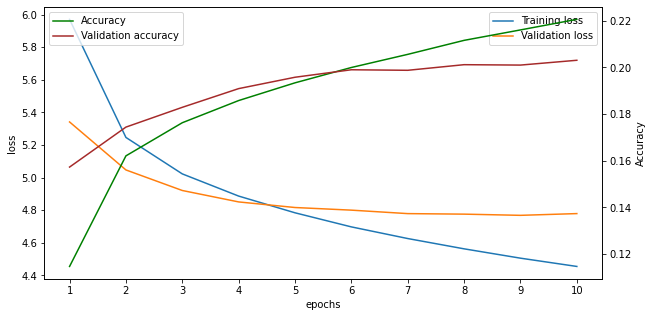

In [ ]:
import matplotlib.pyplot as plt
num_epochs=10

fig,(ax1)=plt.subplots(figsize=(10, 5))
ax2=ax1.twinx()

ax1.plot(range(1, num_epochs+1), history.history['loss'])
ax1.plot(range(1, num_epochs+1), history.history['val_loss'])

ax2.plot(range(1, num_epochs+1), history.history['accuracy'], color='green')
ax2.plot(range(1, num_epochs+1), history.history['val_accuracy'], color='brown')
plt.xticks(list(range(1, num_epochs+1)))

ax1.legend(['Training loss', 'Validation loss'])
ax2.legend(['Accuracy', 'Validation accuracy'])

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.set_ylabel('Accuracy')

plt.show()

In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/model_kim_harrison.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/model_kim_harrison.h5")
print("Saved model to disk!")

Saved model to disk!


In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/checkpoints/METG-epoch010-words11109-sequence10-minfreq10-loss4.4552-accuracy0.2205-val_loss4.7795-val_accuracy0.2030"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
##model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Kim Harrison/model_kim_harrison.h5")

**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length))
    for t, word in enumerate(sentence):
      x_pred[0, t]= word_indices[word]
    ##print("Generating predictions...")
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
##vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_kim_harrison.txt"

In [ ]:
##model=load_model(model_file)
##vocabulary=open(vocabulary_file, "r").readlines()
##print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
#word_indices=dict((c, i) for i, c in enumerate(words))
#indices_word=dict((i, c) for i, c in enumerate(words))

For generating essays with 250 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=250
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Kim Harrison/", 
                True, "Kim Harrison")
  print("=====================================================")

Seed sentence: he would be dead from the sun unless he had
====Generating text====
Diversity:  0.3
Seed sentence: he would be dead from the sun unless he had
he would be dead from the sun unless he had had a demon to kill me. i was going to
 be the one who had been on it. but i
 was going to be stupid. i was going to get
 out of the church. i was going to have to
 do it, but i was going to be a good
 idea, but i was going to have to be a
 good idea. the pixy was in the back of the
 church, and i was going to be sure what he
 was going to do about it. i was going to
 be a good idea. i was going to be in
 a few minutes. i was going to have to be
 a good one. i was going to be the one
 who had to be in a few minutes. i was
 going to be out of the church and not the
 same time i had been in the church. i was
 still on the back of the church, and i was
 glad i was going to be in the ever-after. i
 was going to be sure he had a good time
 to make a demon or not. i was going to
 be a good ide

For generating a small essay of 300 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Kim Harrison/", 
                True, "Kim Harrison")
  print("=====================================================")

Seed sentence: who i was with. and then we were past him,
====Generating text====
Diversity:  0.3
Seed sentence: who i was with. and then we were past him,
who i was with. and then we were past him, him, a big black charm and a red silk coat
 of water on his head. the woman was in the
 kitchen. the wind was a tiny sound of a black
 charm and a black leather powder and a black coat.
 the cool air was almost in the back of the
 church. i was going to be sure how much of
 my mother had been in the church. i was going
 to be the one that was going to be a
 good thing. i was going to be a good idea,
 but it was like i was going to be in
 a good mood, but i was still going to be
 in the back of the church. i was going to
 be there to make a lot of time to make
 a circle when you get in the church. i don’t
 want to be in the church for a few minutes
 to get out of the church. i was going to
 have to be a lot more more than the last
 time i had to get out of the way. i
 was going to have to be

For generating novels with 10000 words

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10000
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Kim Harrison/", 
                True, "Kim Harrison")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 i could feel the the demon smut on the first
 disguise pot in the back was to get the fib
 to make the woman from the kitchen. the circle was
 so close to the ley line i’d hit out, and
 i wondered how a few men were talking to it
 and was really so warm and loud. “i froze at
 the few people who doesn’t like you in the church.
 you don’t want me to have an entire ley line
 to get out of the fib, and i had to
 get rid of it and the night i was going
 to have to do was touch me. i was going
 to be here if i had to do it if
 i was in the main room, but i was going
 to find the i.s. hours with the demon on the
 garden where the undead were was lost in the human
 the morning i had turned on, and i was surprised
 i could see the light on the line and and
 a kid in the kitchen. she had a handful of
 hot gold and the other would be and hit the
 floor. the demon had onto the floor as i pulled
 my eyes over the tree and pushed the drawer away.
 

For generating novels with 10500 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Kim Harrison/", True, "Kim Harrison")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 look at him. “like you have to be a little
 in the same time you wouldn’t take a world from
 the ever-after and a car to be parked in a
 circle. it was the only way to be here for
 a few years ago in the ever-after. i was almost
 still in the kitchen. my heart pounded, and i stiffened
 as she pulled his hands into his hand. ivy was
 on the center counter and my back to the foyer,
 and he looked down at the memory of it. the
 last of the i.s. wasn’t in the same morning if
 it was the same time i was in the kitchen.
 i was uneasy, but i was so sure that i
 was still looking for it without the narrow space of
 the street and the stairs with the water watching us.
 it was a huge store of a cold mundane things.
 that was really bad for him to do that a
 box of ever-after with a curse and talk to me
 about a demon on the other side of the lines.
 i was going to have to get rid of it
 or get out of my way. i was going to
 be in case i was go